In [23]:
import torch
import torch.nn as nn
# from torch.nn import init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision
import torch.autograd as autograd
from PIL import Image
import imp
import os
import sys
import math
import time
import random
import shutil
# import cv2
import scipy.misc
from glob import glob
import sklearn
import logging

from tqdm import tqdm
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('bmh')

%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [24]:
from dcgan import DCGAN_D, DCGAN_G

In [25]:
if not torch.cuda.is_available():
    print("SORRY: No CUDA device")

In [26]:
imageSize = 64
batchSize = 64

In [27]:
nz = 100
ngf = 64
ndf = 64
nc = 3

ngpu = 1
cuda = True

### Load data

In [28]:
transform = transforms.Compose([
    transforms.Scale(imageSize),
    transforms.CenterCrop(imageSize),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


# dataset = dset.MNIST('MNIST', transform=transform, download=True)
dataset = dset.ImageFolder('celeba', transform=transform)
dataloader = DataLoader(dataset, batch_size=batchSize, shuffle=True)

### Custom weights initialization called on netG and netD

In [29]:
optnetG = ''
optnetD = ''

In [30]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [60]:
netG = DCGAN_G(imageSize, nz, nc, ngf, ngpu)

netG.apply(weights_init)
if optnetG != '': # load checkpoint if needed
    netG.load_state_dict(torch.load(optnetG))
print(netG)

DCGAN_G (
  (main): Sequential (
    (initial.100-512.convt): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial.512.batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (initial.512.relu): ReLU (inplace)
    (pyramid.512-256.convt): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.256.relu): ReLU (inplace)
    (pyramid.256-128.convt): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.128.relu): ReLU (inplace)
    (pyramid.128-64.convt): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.64.relu): ReLU (inplace)
    (final.64-3.convt): 

In [61]:
netD = DCGAN_D(imageSize, nz, nc, ndf, ngpu)

netD.apply(weights_init)
if optnetD != '':
    netD.load_state_dict(torch.load(optnetD))
print(netD)

DCGAN_D (
  (main): Sequential (
    (initial.conv.3-64): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (initial.relu.64): LeakyReLU (0.2, inplace)
    (pyramid.64-128.conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.128.relu): LeakyReLU (0.2, inplace)
    (pyramid.128-256.conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.256.relu): LeakyReLU (0.2, inplace)
    (pyramid.256-512.conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.512.batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.512.relu): LeakyReLU (0.2, inplace)
    (final.512-1.conv): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


### Setup input and output tensors

In [62]:
input = torch.FloatTensor(batchSize, 3, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
one = torch.FloatTensor([1])
mone = one * -1

if cuda:
    netD.cuda()
    netG.cuda()
    input = input.cuda()
    one, mone = one.cuda(), mone.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

# input = Variable(input)
# label = Variable(label)
# noise = Variable(noise)
# fixed_noise = Variable(fixed_noise)

### Setup optimizer

In [63]:
lr = 0.0002
beta1 = 0.5

In [64]:
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Train

In [65]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [93]:
clamp_lower = 0.01
clamp_upper = 0.01

diter = 5
niter = 10

[0/10][1000/3166][10] Loss_D: 0.01 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82
[0/10][2000/3166][20] Loss_D: 0.01 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82
[0/10][3000/3166][125] Loss_D: 0.01 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82
[1/10][1000/3166][359] Loss_D: 0.01 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82


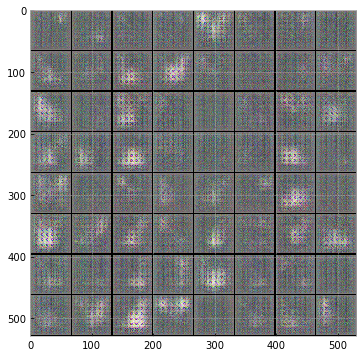

[1/10][2000/3166][540] Loss_D: 0.02 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82
[1/10][3000/3166][740] Loss_D: 0.01 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82
[2/10][1000/3166][974] Loss_D: 0.02 Loss_G: 0.83 Loss_D_real: 0.84 Loss_D_fake 0.82


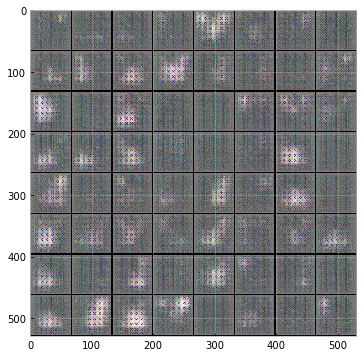

[2/10][2000/3166][1155] Loss_D: 0.01 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82
[2/10][3000/3166][1355] Loss_D: 0.01 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82


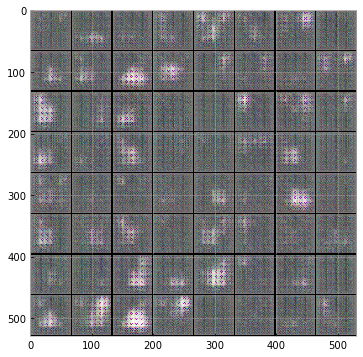

[3/10][1000/3166][1570] Loss_D: 0.00 Loss_G: 0.83 Loss_D_real: 0.82 Loss_D_fake 0.82
[3/10][2000/3166][1770] Loss_D: 0.01 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82
[3/10][3000/3166][1970] Loss_D: 0.01 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82


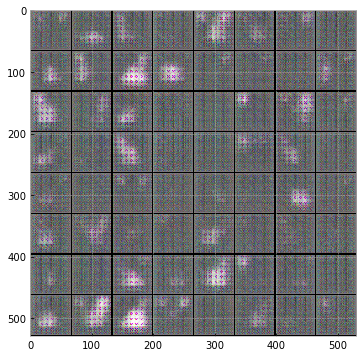

[4/10][1000/3166][2201] Loss_D: 0.01 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82
[4/10][2000/3166][2401] Loss_D: 0.01 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82


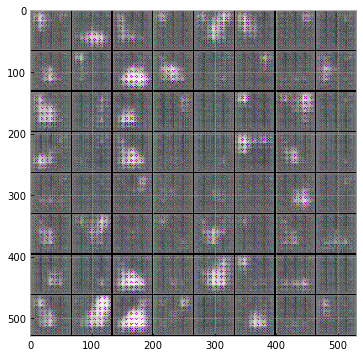

[4/10][3000/3166][2582] Loss_D: 0.01 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82
[5/10][1000/3166][2816] Loss_D: 0.01 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82


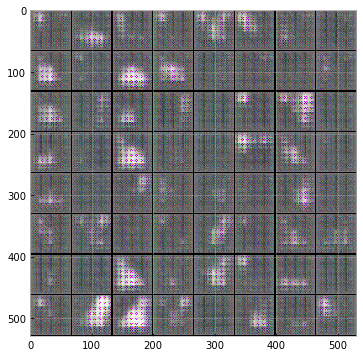

[5/10][3000/3166][3197] Loss_D: 0.02 Loss_G: 0.83 Loss_D_real: 0.84 Loss_D_fake 0.82
[6/10][1000/3166][3431] Loss_D: 0.02 Loss_G: 0.83 Loss_D_real: 0.84 Loss_D_fake 0.82


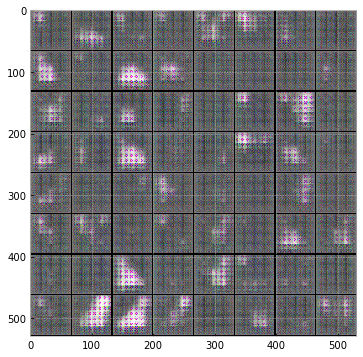

[6/10][2000/3166][3612] Loss_D: 0.01 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82
[6/10][3000/3166][3812] Loss_D: 0.01 Loss_G: 0.83 Loss_D_real: 0.83 Loss_D_fake 0.82


KeyboardInterrupt: 

In [94]:
gen_iterations = 0
losses = []
for epoch in range(niter):
    data_iter = iter(dataloader)
    i = 0
    while i < len(dataloader):
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update

        # train the discriminator Diters times
        if gen_iterations < 25 or gen_iterations % 500 == 0:
            Diters = 100
        else:
            Diters = diter
        
        j = 0
        while j < Diters and i < len(dataloader):
            j += 1

            # clamp parameters to a cube
            for p in netD.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)

            data = data_iter.next()
            i += 1

            # train with real
            real_cpu, _ = data
            netD.zero_grad()
            batch_size = real_cpu.size(0)

            if cuda:
                real_cpu = real_cpu.cuda()
            input.resize_as_(real_cpu).copy_(real_cpu)
            inputv = Variable(input)

            errD_real = netD(inputv)
            errD_real.backward(one)

            # train with fake
            noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
            noisev = Variable(noise, volatile = True) # totally freeze netG
            fake = Variable(netG(noisev).data)
            inputv = fake
            errD_fake = netD(inputv)
            errD_fake.backward(mone)
            errD = errD_real - errD_fake
            optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        netG.zero_grad()
        # in case our last batch was the tail batch of the dataloader,
        # make sure we feed a full batch of noise
        noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        errG = netD(fake)
        errG.backward(one)
        optimizerG.step()
        gen_iterations += 1
        
        
        losses.append((errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))
        if i% 1000 == 0:
            print('[{}/{}][{}/{}][{}] Loss_D: {:.3f} Loss_G: {:.3f} Loss_D_real: {:.3f} Loss_D_fake {:.3f}'\
              .format(epoch, niter, i, len(dataloader), gen_iterations,errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))
        
        if gen_iterations % 500 == 0:
            fake = netG(Variable(fixed_noise, volatile=True))
            fake.data = fake.data.mul(0.5).add(0.5)
            show(vutils.make_grid(fake.data).cpu())
            # vutils.save_image(fake.data, '{0}/fake_samples_{1}.png'.format(opt.experiment, gen_iterations))

    # do checkpointing
    torch.save(netG.state_dict(), '{0}/netG_epoch_{1}.pth'.format('save', epoch))
    torch.save(netD.state_dict(), '{0}/netD_epoch_{1}.pth'.format('save', epoch))


### Show

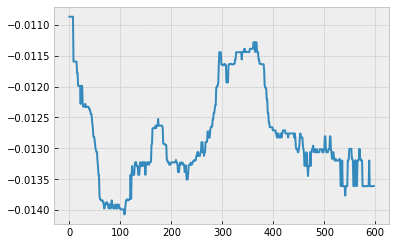

In [92]:
Loss_D = np.array([i[0] for i in losses])
med_filtered_loss = scipy.ndimage.filters.median_filter(-Loss_D, 101)

plt.plot(med_filtered_loss)

In [46]:
def show(img, fs=(6,6)):
    plt.figure(figsize = fs)
#     plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')
    plt.imshow(np.transpose(img.numpy(), (1,2,0)))
    plt.show()

In [43]:
fake = netG(Variable(fixed_noise, volatile=True))
fake.data = fake.data.mul(0.5).add(0.5)

In [50]:
fake.data.size()

torch.Size([64, 3, 64, 64])

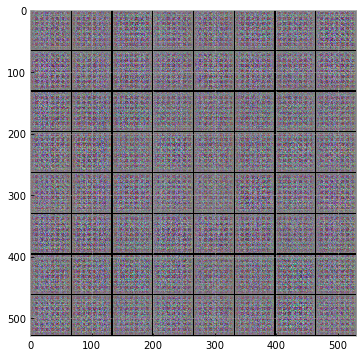

In [51]:
show(vutils.make_grid(fake.data).cpu())